In [78]:
import numpy as np
import igraph as ig 
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
import math
import networkx as nx

Helper Methods

In [3]:
# load all dataset names and graph data from "graphs" directory
def get_data(dir="graphs/HGP/"):
    files = sorted(listdir(dir))

    dataset_names = []
    wrong_graphs, correct_graphs = [], []

    for file in files:
        if file.endswith("wrong_graphs.npy"):
            dataset_names.append(file.replace("_HGP_wrong_graphs.npy", ""))

            data_wrong_graphs = np.load(dir+file, allow_pickle=True)
            wrong_graphs.append(data_wrong_graphs)

        if file.endswith("right_graphs.npy"):
            data_right_graphs = np.load(dir+file, allow_pickle=True)
            correct_graphs.append(data_right_graphs)

    return dataset_names, wrong_graphs, correct_graphs

In [106]:
def get_cna_metrics(datasets: list):
    # maps the index of graph_metrics to the metric name (needed to label automatically in visualization)
    index_to_metric = {0: 'Number of Vertices',
                       1: 'Number of Cliques',
                       2: 'Maximum Degree',
                       3: 'Minimum Degree',
                       4: 'Average Degree',
                       5: 'Correlation Coefficient',
                       6: 'Density',
                       7: 'Average Neighbor Degree',
                       8: 'Clustering Coefficient',
                       9: 'Edge Connectivity'}

    # list of graph metrics for each dataset
    all_graph_metrics = []

    for i, dataset in enumerate(datasets):
        graph_metrics = np.zeros((len(dataset), len(index_to_metric.keys())))

        for j, graph_data in enumerate(dataset):
            graph = ig.Graph.from_networkx(graph_data)

            vcount = graph.vcount()
            cliques = graph.clique_number()
            max_deg = graph.maxdegree()
            min_degree = min(graph.degree(), default=0)
            avg_deg = np.average(graph.degree())
            assortativity = graph.assortativity_degree(directed=False)

            density = graph.density(loops=True)
            avg_neighbor_deg = np.average(np.array(graph.knn()[0]))
            # graph.knn()[1] knn for each node degree.  The zeroth element of this list corresponds to vertices of degree 1.

            clustering_coef = graph.transitivity_undirected()
            connectivity = graph.edge_connectivity(checks=False)

            graph_metrics[j] = np.array([vcount, cliques, max_deg,
                                         min_degree,  avg_deg, assortativity, density, avg_neighbor_deg, clustering_coef, connectivity])

        all_graph_metrics.append(graph_metrics)
    return all_graph_metrics, index_to_metric


In [107]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return print(pd.DataFrame(rows_list))


In [120]:
def plot_boxplot(wrong_class_metrics: list, correct_class_metrics: list, index: int, index_to_metric: dict, dataset_names: list):
    data_wrong_class = [dataset[:, index]
                        for dataset in wrong_class_metrics]
    
    data_right_class = [dataset[:, index]
                        for dataset in correct_class_metrics]

    #filter out nan values
    data_wrong_class = [[value for value in dataset if not math.isnan(value)]
                        for dataset in data_wrong_class]
    data_right_class = [[value for value in dataset if not math.isnan(value)]
                        for dataset in data_right_class]

    x = np.arange(len(dataset_names))
    width = 0.4
    distance = 0.22

    plt.rcParams.update({'font.size': 20})

    fig, ax = plt.subplots(figsize=(17,6))
    meanpointprops = dict(marker='D', markerfacecolor='b',
                          markeredgecolor='b')
   
    medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
    medianprops_2 = dict(linestyle='-', linewidth=2.5, color='dodgerblue')

    boxplot_wrong = ax.boxplot(data_wrong_class,
                               positions=x-distance, widths=width, meanprops=meanpointprops, meanline=False,
                               showmeans=True, medianprops=medianprops)
    boxplot_right = ax.boxplot(data_right_class,
                               positions=x+distance, widths=width, meanprops=meanpointprops, meanline=False,
                               showmeans=True, medianprops=medianprops_2)

    set_box_color(boxplot_wrong, '#D7191C')
    set_box_color(boxplot_right, 'g')

    metric = index_to_metric[index]
    ax.set_title(f"{metric} of Classified Graphs")
    ax.set_ybound(lower=0)
    ax.set_xticks(x, dataset_names)
    ax.set_ylabel(metric)
    ax.set_xlabel('Dataset')
    fig.tight_layout()

    #get_box_plot_data(dataset_names, boxplot_wrong)
    print()
    #get_box_plot_data(dataset_names, boxplot_right)


    # helpful operations to create labels that are visible in the legend
    plt.plot([], c='#D7191C', label='Wrongly Classified Graphs')
    plt.plot([], c='g', label='Correctly Classified Graphs')
    plt.plot([], marker='D', linestyle='None', label='Mean', color='b')
    plt.legend()
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


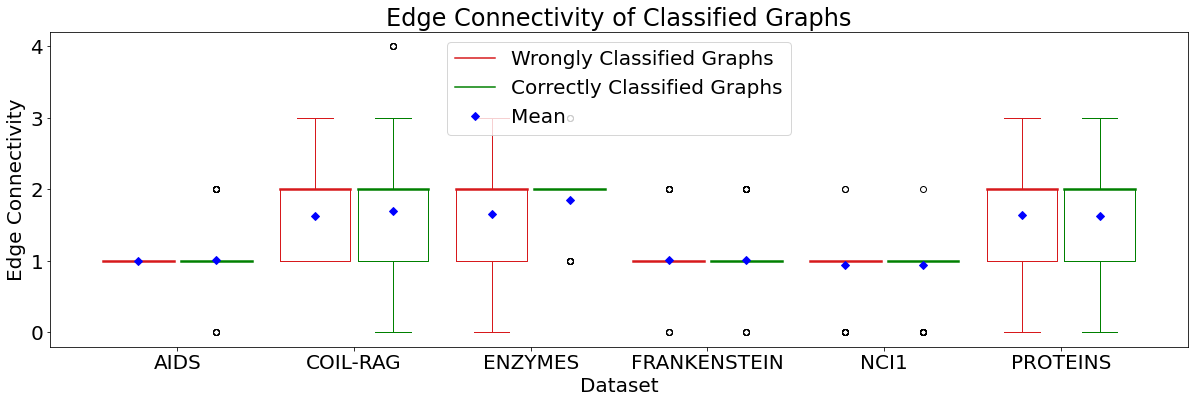

In [127]:
dataset_names, wrong_graphs, correct_graphs = get_data()

all_graph_metrics_wrong, index_to_metric = get_cna_metrics(wrong_graphs)
all_graph_metrics_right, index_to_metric = get_cna_metrics(correct_graphs)

plot_boxplot(all_graph_metrics_wrong, all_graph_metrics_right,
             9, index_to_metric, dataset_names)


In [137]:
dataset_names, wrong_graphs, correct_graphs

wrong = [len(dt) for dt in wrong_graphs]
correct = [len(dt) for dt in correct_graphs]
error_rate = ["{:,.3f}".format((wrong[i] / (wrong[i]+correct[i]))) for i in range(len(dataset_names))]

df = pd.DataFrame(index=dataset_names, data=zip(wrong,  correct, error_rate))
df

,0,1,2
AIDS,3,297,0.010
COIL-RAG,51,534,0.087
ENZYMES,62,28,0.689
FRANKENSTEIN,291,360,0.447
NCI1,173,444,0.280
PROTEINS,47,120,0.281


In [144]:
z = zip(wrong,  correct, error_rate)
for i in range(len(dataset_names)):
    print(f"& {wrong[i]} & {correct[i]} & {error_rate[i]} &")

& 3 & 297 & 0.010 &
& 51 & 534 & 0.087 &
& 62 & 28 & 0.689 &
& 291 & 360 & 0.447 &
& 173 & 444 & 0.280 &
& 47 & 120 & 0.281 &
